In [179]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xinwangcs/stressor-cause-of-mental-health-problem-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\xinwangcs\stressor-cause-of-mental-health-problem-dataset\versions\1


In [180]:
import pandas as pd
import numpy as np
import os
FILES = []
for file in os.listdir(path):
    if file.endswith(".json"):
        PATH = os.path.join(path, file)
        FILES.append(PATH )
print("Files in dataset:", FILES)



Files in dataset: ['C:\\Users\\user\\.cache\\kagglehub\\datasets\\xinwangcs\\stressor-cause-of-mental-health-problem-dataset\\versions\\1\\stressor_test.json', 'C:\\Users\\user\\.cache\\kagglehub\\datasets\\xinwangcs\\stressor-cause-of-mental-health-problem-dataset\\versions\\1\\stressor_train.json']


In [181]:
import json

def load_data2dataframe(file):
    """
    讀取 JSON 文件並將其轉換為 Pandas DataFrame。
    參數:
        file (str): 檔案路徑。

    錯誤回報:
        ValueError: 如果在資料集目錄中找不到 JSON 檔案。
        ValueError: 如果指定的 JSON 檔案不存在。
        
    回傳:
        pd.DataFrame: 包含文本、壓力源類別、壓力源詞和時間間隔的 DataFrame。
    """
    if not FILES:
        raise ValueError("No JSON files found in the dataset directory.")
    if not os.path.exists(file):
        raise ValueError(f"File '{file}' does not exist.")
    with open(file, encoding="utf-8") as f:
        data = json.load(f)
        if not isinstance(data, list):
            raise ValueError(f"Expected a list in JSON file, got {type(data)}")
        temp = []
        for item in data:
            #print(item)
            TEXT = item["text"]
            INTERVAL = item["interval"]
            try:
                STRESSOR_class = item["labels"][0][0]
                STRESSOR_WORD = item["labels"][0][4]
            except IndexError:
                STRESSOR_class = np.nan
                STRESSOR_WORD = np.nan
            temp.append((TEXT, STRESSOR_class, STRESSOR_WORD, INTERVAL))

    # Convert list of tuples to DataFrame with column names
    return pd.DataFrame(temp, columns=["text", "stressor_class", "stressor_word", "interval"])

# Ensure each element is a DataFrame before concatenation
dataframes = [load_data2dataframe(f) for f in FILES]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,text,stressor_class,stressor_word,interval
0,Why are there always trivial matters in life t...,T1,financial,8
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8
2,"In the coming March, my work pressure will be ...",T1,work,8
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8


In [182]:
df.dropna(inplace=True)
df.isna().sum()

text              0
stressor_class    0
stressor_word     0
interval          0
dtype: int64

In [183]:
df_copy = df.copy()

In [184]:
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# 載入 lemmatizer
lemmatizer = WordNetLemmatizer()

def normalize(text):
    # 1. 轉小寫
    text = text.lower()
    # 2. 去標點
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 3. 去停用詞
    text = remove_stopwords(text) if len(text.split()) > 1 else text
    # 4. 詞形還原
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized



In [185]:
from gensim import corpora, models
from gensim.utils import simple_preprocess
texts = [simple_preprocess(word) for word in df_copy["stressor_word"]]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10):
    coherence_values = []
    for num_topics in range(start, limit+1):
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary,
                         num_topics=num_topics, 
                         passes=10,
                         random_state = num_topics)
        coherence_model = CoherenceModel(model=model, 
                                         texts=texts, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values

coherence_values = compute_coherence_values(dictionary , 
                                            corpus ,
                                            texts,
                                            start=2,
                                            limit=10)

In [ ]:
temp = []
for i in range(1,21):
    coherence_values = compute_coherence_values(dictionary , 
                                                corpus ,
                                                texts,
                                                start=2,
                                                limit=10)
    temp.append(coherence_values)
    
coherence_values = np.mean(temp, axis=0)
temp.clear()

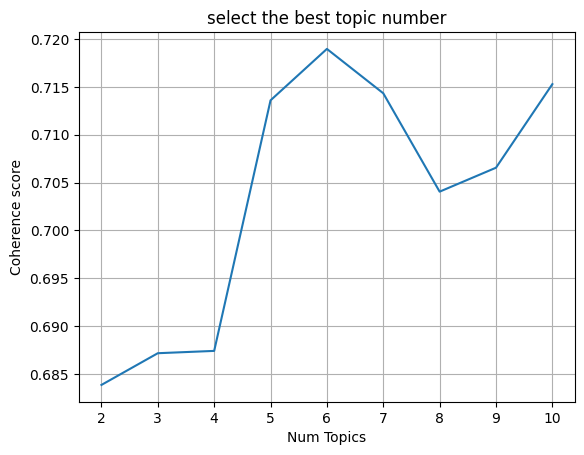

In [233]:
import matplotlib.pyplot as plt
x = range(2, 11)
plt.plot(x, coherence_values)
plt.xticks(x)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("select the best topic number")
plt.show()


In [212]:
# 建立 LDA 模型
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=50)

# 取得每筆資料的主題分佈
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# 取最大主題編號作為群標籤
topic_labels = [max(dist, key=lambda x: x[1])[0] for dist in topic_distributions]

In [213]:
df_copy["topic"] = topic_labels
df_copy.head(10)

,text,stressor_class,stressor_word,interval,topic
0,Why are there always trivial matters in life t...,T1,financial,8,1
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8,4
2,"In the coming March, my work pressure will be ...",T1,work,8,2
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8,1
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8,2
5,Staying up late is irreparable damage. I've st...,T1,learn,8,2
6,Watching decompressing videos on Douyin increa...,T1,decompressing videos,8,1
7,The pressure from scrolling through Xiaohongsh...,T1,Xiaohongshu,8,4
8,I'm out of money... the baby clothing store is...,T1,baby clothing store,8,1
9,"I am currently feeling the pressure from ez, a...",T1,ez,8,2


In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df_copy["text"], df_copy["topic"], test_size=0.2 , stratify=df_copy["topic"])

vectorizer = TfidfVectorizer(stop_words="english")

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# 模型比對


SVC
---

In [215]:
SVC_model = SVC(kernel="linear",
                probability=True,
                class_weight="balanced", random_state=42)
SVC_model.fit(X_train_vectorized, y_train)  
y_pred = SVC_model.predict(X_test_vectorized)  
print(SVC_model.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.5545796737766625
              precision    recall  f1-score   support

           0       0.50      0.63      0.56       149
           1       0.53      0.49      0.51       124
           2       0.65      0.57      0.61       227
           3       0.56      0.54      0.55       145
           4       0.51      0.51      0.51       152

    accuracy                           0.55       797
   macro avg       0.55      0.55      0.55       797
weighted avg       0.56      0.55      0.56       797



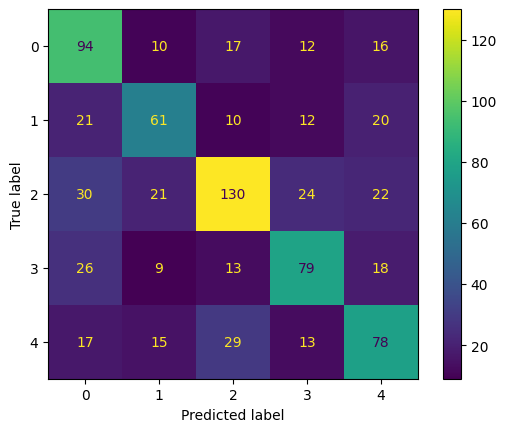

In [216]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SVC_model, X_test_vectorized, y_test)
plt.show()

ComplementNB
---

In [217]:
from sklearn.naive_bayes import MultinomialNB ,ComplementNB
NB = ComplementNB()
NB.fit(X_train_vectorized, y_train)  
y_pred = NB.predict(X_test_vectorized)  
print(NB.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.5156838143036386
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       149
           1       0.50      0.47      0.48       124
           2       0.54      0.58      0.56       227
           3       0.54      0.50      0.52       145
           4       0.47      0.49      0.48       152

    accuracy                           0.52       797
   macro avg       0.51      0.51      0.51       797
weighted avg       0.52      0.52      0.52       797



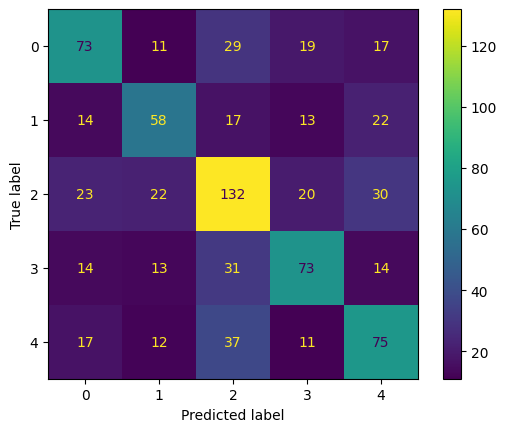

In [218]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(NB, X_test_vectorized, y_test)
plt.show()

RandomForestClassifier
---

In [219]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(class_weight="balanced")
RF.fit(X_train_vectorized, y_train)  
y_pred = RF.predict(X_test_vectorized)  
print(RF.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.5734002509410289
              precision    recall  f1-score   support

           0       0.62      0.61      0.61       149
           1       0.68      0.48      0.56       124
           2       0.54      0.74      0.62       227
           3       0.58      0.48      0.53       145
           4       0.53      0.45      0.49       152

    accuracy                           0.57       797
   macro avg       0.59      0.55      0.56       797
weighted avg       0.58      0.57      0.57       797



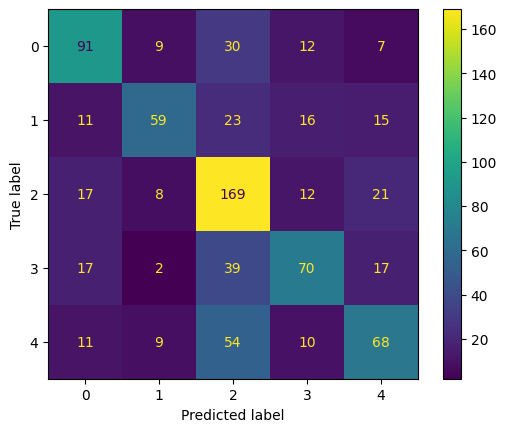

In [220]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(RF, X_test_vectorized, y_test)
plt.show()

LogisticRegression
---

In [221]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight="balanced")
LR.fit(X_train_vectorized, y_train)  
y_pred = LR.predict(X_test_vectorized)  
print(LR.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.5759096612296111
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       149
           1       0.54      0.54      0.54       124
           2       0.68      0.59      0.63       227
           3       0.58      0.58      0.58       145
           4       0.50      0.54      0.52       152

    accuracy                           0.58       797
   macro avg       0.57      0.57      0.57       797
weighted avg       0.58      0.58      0.58       797



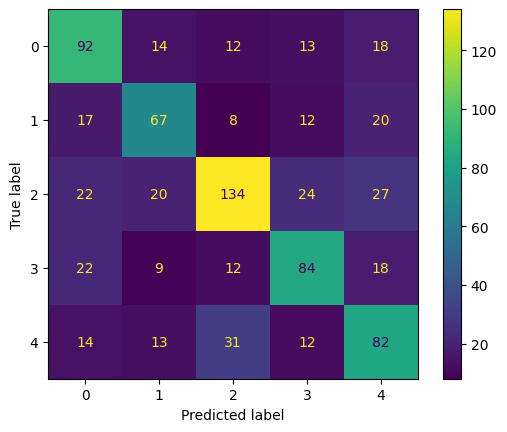

In [222]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(LR, X_test_vectorized, y_test)
plt.show()

交叉驗證
---

In [223]:
from sklearn.model_selection import cross_val_score

print("NB : ",cross_val_score(NB, X_test_vectorized, y_test, cv=5).mean())
print("RF : ",cross_val_score(RF, X_test_vectorized, y_test, cv=5).mean())
print("LR : " , cross_val_score(LR, X_test_vectorized, y_test, cv=5).mean())
print("SVC : ",cross_val_score(SVC_model, X_test_vectorized, y_test, cv=5).mean())

NB :  0.42033018867924526
RF :  0.47804245283018876
LR :  0.49557389937106916
SVC :  0.4741981132075471


In [224]:
from sklearn.model_selection import StratifiedKFold
SVC_model_score = cross_val_score(SVC_model, 
                           X_test_vectorized, 
                           y_test, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print(SVC_model_score)

[0.475      0.48125    0.4591195  0.52830189 0.49056604]


In [225]:
from sklearn.model_selection import StratifiedKFold
LR_score = cross_val_score(LR, 
                           X_test_vectorized, 
                           y_test, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print(LR_score)

[0.425      0.5125     0.48427673 0.5408805  0.47169811]


# 超參數搜尋

In [226]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_param_grid = {
    'C': [1, 2,3,4],
    'kernel': ['linear' ,'rbf'],  
    'class_weight': ['balanced'],
    'probability': [True]
}

svc_model = SVC(random_state=42)
grid_svc = GridSearchCV(svc_model, svc_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_vectorized, y_train)

print(grid_svc.best_score_)
print(grid_svc.best_params_)

0.5909632239681502
{'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf', 'probability': True}


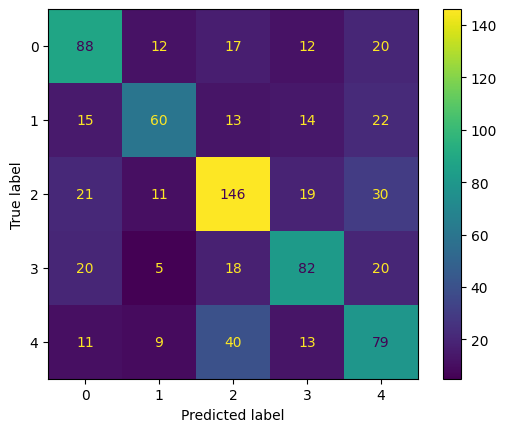

In [227]:
ConfusionMatrixDisplay.from_estimator(grid_svc.best_estimator_, X_test_vectorized, y_test)
plt.show()

In [228]:
from sklearn.linear_model import LogisticRegression

lr_param_grid = {
    'C': [1,2,3,4],
    'penalty': ['l2','l1'],
    'class_weight': ['balanced'],
    'solver': ['liblinear'],
}

lr_model = LogisticRegression(random_state=42, max_iter=1000)
grid_lr = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_vectorized, y_train)

print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.6226453349606059
{'C': 2, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [229]:
print(classification_report(y_test, grid_lr.predict(X_test_vectorized)))


              precision    recall  f1-score   support

           0       0.62      0.68      0.65       149
           1       0.62      0.57      0.59       124
           2       0.66      0.69      0.67       227
           3       0.60      0.53      0.56       145
           4       0.55      0.55      0.55       152

    accuracy                           0.61       797
   macro avg       0.61      0.60      0.60       797
weighted avg       0.61      0.61      0.61       797



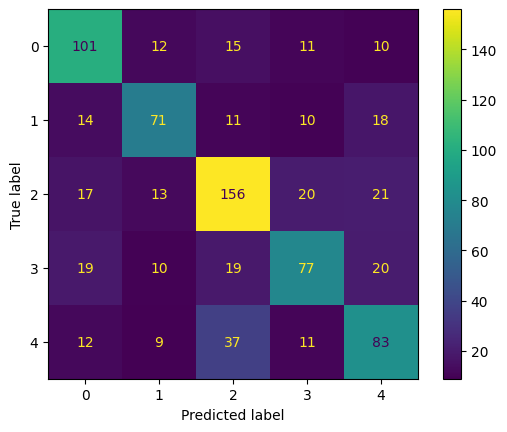

In [230]:
ConfusionMatrixDisplay.from_estimator(grid_lr.best_estimator_, X_test_vectorized, y_test)
plt.show()

In [231]:

grid_lr_score = cross_val_score(grid_lr, 
                           X_test_vectorized, 
                           y_test, 
                           cv=5)
print(grid_lr_score)
print(grid_lr_score.mean())


[0.525      0.56875    0.54716981 0.46540881 0.47798742]
0.5168632075471697


In [209]:
# # 使用最佳的邏輯回歸模型對原始資料表 df_copy["text"] 進行預測
# X_all = df_copy["text"]
# y_all_pred = grid_lr.predict(vectorizer.transform(X_all))

# # 將預測結果加入資料表
# df_copy["predicted_topic"] = y_all_pred
# df_copy[["text", "topic", "predicted_topic"]].head()